In [97]:
import pandas as pd
tweets_all = pd.read_csv('Raw tweets_December27_6:34AM_CST_alldata.csv')
replies = pd.read_csv('Raw tweets_December27_6:34AM_CST_Replies.csv')
retweets = pd.read_csv('Raw tweets_December27_6:34AM_CST_Retweets.csv')
tweets_clean = pd.read_csv('Raw tweets_December27_6:34AM_CST_NoReplies_NoRetweets.csv')
print('The number of tweets:',len(tweets_all['tweets']))
print('The number of replies:',len(replies['tweets']))
print('The number of retweets:',len(retweets['tweets']))
print('The number of clean tweets:',len(tweets_clean['tweets']))

The number of tweets: 11091
The number of replies: 2221
The number of retweets: 3930
The number of clean tweets: 4940


In [98]:
'''---------------------------------------------------------------------------------------
Text cleaning:remove @user, URLs, hashtags, non-alphabets characters and special characters (&amp)
保留lowercase，轉換為root form，去除長度小於4的單詞'''
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
import pandas as pd
text = tweets_clean
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split():
        if '@' not in words: #remove @users
            #words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = words.lower()# lower form
                        words = re.sub(r'[^a-zA-Z]', ' ', words) #replace non-alphabets characters with space. From "can't" to "can t"
                        if len(words)>3:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if token not in stop_words:
            token = porter.stem(token) #root form
            doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

In [99]:
text['processed'].head(10)

0    unpreced time devot attent brighter futur cell...
1                     chat happen cellular agricultur 
2    climat chao climat transform proud name compan...
3    holiday feel littl differ year still excit fut...
4                      speak today iit virtual summit 
5    team commit perfect delici product last impact...
6    interest year thank commun support enthusiasm ...
7    winner best brightest compani work nation area...
8    want delici meat product help environ product ...
9    happi join intern associ food protect mission ...
Name: processed, dtype: object

In [14]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [100]:
'''---------------------------------------------------------------------------------------
生成bigram：基於gensim.model.phrase的方式'''
import gensim
import gensim.corpora as corpora
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #將句子變為token，生成list
data_words = list(sent_to_words(text['processed'])) #tokenization
bigram = gensim.models.Phrases(data_words,min_count=1,threshold=1)
'''mincount：兩個單詞共同出現次數小於該值，則不會被考慮為bigram，
threshold：Phrases功能中會生成一個'phase score'，超過這個score的bigram會生成在最終結果中，總的來說，mincount越小，threshold越小，最終生成的bigram越多'''
bigram_mod = gensim.models.phrases.Phraser(bigram) #生成bigram
def make_bigrams(texts): #生成bigram
    return [bigram[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

In [101]:
data_words_bigrams[:10]

[['unpreced_time',
  'devot',
  'attent',
  'brighter_futur',
  'cell_base',
  'meat',
  'bring',
  'peopl',
  'togeth',
  'around_dinner',
  'tabl',
  'proud_team',
  'reflect',
  'last_year',
  'holiday',
  'parti_celebr',
  'commun'],
 ['chat', 'happen_cellular', 'agricultur'],
 ['climat',
  'chao',
  'climat',
  'transform',
  'proud_name',
  'compani',
  'recognit',
  'potenti',
  'tackl_climat',
  'crisi',
  'meaning',
  'measur',
  'solut'],
 ['holiday',
  'feel',
  'littl_differ',
  'year',
  'still',
  'excit',
  'futur',
  'part',
  'cozi',
  'famili',
  'meal',
  'would',
  'want',
  'cook',
  'holiday',
  'cell_base',
  'meat'],
 ['speak_today', 'iit', 'virtual_summit'],
 ['team_commit', 'perfect', 'delici_product', 'last_impact', 'gener'],
 ['interest',
  'year',
  'thank',
  'commun',
  'support_enthusiasm',
  'encourag',
  'continu',
  'work_bring',
  'best',
  'tastiest',
  'product',
  'tabl',
  'grate',
  'opportun',
  'share_journey'],
 ['winner',
  'best',
  'bright

In [102]:
'''---------------------------------------------------------------------------------------
counting coherence score,使用的是u_mass'''
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

([<matplotlib.axis.XTick at 0x7f9f873ff550>,
 <a list of 30 Text xticklabel objects>)

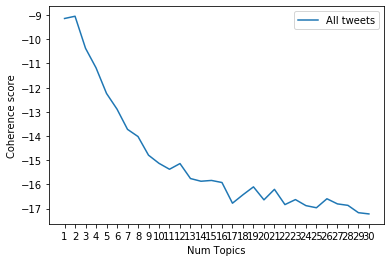

In [103]:
limit=31; start=1; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))

In [104]:
'''---------------------------------------------------------------------------------------
print bigrams within each topic'''

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=12,random_state=5,alpha='auto',per_word_topics=True)
for idx, topic in lda_model.show_topics(formatted=False,num_topics=12,num_words= 400):
    print('\n',end='')
    print('Topic:',idx)
    for w in topic:
        if '_' in w[0]:
            print(round(w[1],4),'*',w[0],', ',end='',sep='')


Topic: 0
0.0102*clean_meat, 0.0076*isra_startup, 0.0045*break_news, 0.0044*full_time, 0.0041*altern_protein, 0.0039*food_product, 0.0036*clean_seafood, 0.0026*well_done, 0.0026*climat_chang, 0.0025*lab_grown, 0.0025*execut_assist, 0.0025*food_thought, 0.0023*import_develop, 0.0023*wild_caught, 0.0023*thank_highlight, 0.0017*great_coverag, 0.0015*cruelti_free, 0.0015*innov_sustain, 0.0013*look_bright, 0.0013*join_convers, 0.0012*meat_market, 0.0012*world_eat, 0.0012*need_increas, 0.0012*thank_interest, 0.0012*excit_work, 0.0012*discuss_cell, 0.0012*import_discuss, 0.0012*could_take, 0.0012*shiok_meat, 0.0011*mani_year, 0.001*suppli_chain, 0.0009*thank_everyon, 0.0009*know_like, 0.0009*cultur_meat, 0.0008*cell_base, 0.0007*base_meat, 0.0007*talent_chef, 0.0007*game_changer, 0.0007*sound_like, 0.0007*food_beverag, 0.0007*proud_part, 0.0007*singl_cell, 0.0006*global_food, 0.0006*futur_food, 0.0005*memphi_meat, 0.0005*free_meat, 0.0004*delici_meat, 0.0004*famili_thank, 0.0004*use_tool, 0.0

0.0051*cell_base, 0.0049*thank_share, 0.0046*cultiv_meat, 0.0033*suppli_chain, 0.0032*great_talk, 0.0031*meat_anim, 0.0031*choic_make, 0.0026*feed_billion, 0.0026*food_futur, 0.0026*honor_part, 0.0025*cellular_agricultur, 0.0024*long_term, 0.0023*co_founder, 0.0022*food_system, 0.0022*product_facil, 0.0021*futur_product, 0.0021*read_stori, 0.0021*anim_free, 0.0016*bring_product, 0.0016*food_industri, 0.0016*better_thank, 0.0015*scale_product, 0.0015*work_toward, 0.0014*plant_base, 0.0014*thank_featur, 0.0014*protein_sourc, 0.0014*excit_join, 0.0014*go_market, 0.0014*sourc_protein, 0.0013*bring_cultiv, 0.0013*pleas_appli, 0.0012*join_team, 0.0012*good_food, 0.0012*stay_tune, 0.0011*meat_eat, 0.0011*thrill_announc, 0.0011*thought_leader, 0.0011*look_littl, 0.0011*convent_produc, 0.0011*help_bring, 0.0011*better_futur, 0.0011*biggest_problem, 0.0011*world_right, 0.0011*highlight_import, 0.0011*report_last, 0.0011*find_way, 0.0011*save_ocean, 0.0011*beyond_meat, 0.0011*spent_talk, 0.0011*e

In [105]:
'''---------------------------------------------------------------------------------------
output LDA，生成一個包含dominant topic，keywords，probability of the topic的csv文件
並通過這個文件，統計各個主題內tweets的數量'''

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text['tweets'])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('dominant topics_December_27_6:34AM_CST_data.csv')
data = pd.read_csv('dominant topics_December_27_6:34AM_CST_data.csv')
# tweets count
print('\n')
print('Number of Tweets within each topic:',data.groupby('Dominant_Topic')['Text'].count())



Number of Tweets within each topic: Dominant_Topic
0.0     454
1.0     388
2.0     364
3.0     389
4.0     414
5.0     337
6.0     335
7.0     742
8.0     423
9.0     314
10.0    431
11.0    349
Name: Text, dtype: int64


In [106]:
table1 = pd.read_excel('Table 1,2,3 December 27 (exclude tweets from ModernMeadow and Eatjust).xlsx',sheet_name=0)
table2 = pd.read_excel('Table 1,2,3 December 27 (exclude tweets from ModernMeadow and Eatjust).xlsx',sheet_name=1)
table3 = pd.read_excel('Table 1,2,3 December 27 (exclude tweets from ModernMeadow and Eatjust).xlsx',sheet_name=2)

In [107]:
table1

,Topic,Bigrams within topics,Number of tweets
0,1,"cell-based, plant-based, world first, alternat...",602
1,2,"clean meat, cultured meat, meat industry, long...",260
2,3,"cultivated meat, make cell, chief scientific, ...",234
3,4,"look forward, breaking news, co-founder, stem ...",260
4,5,"co-founder, cellular agriculture, clean seafoo...",322
5,6,"raise million, cultivated meat, future food, t...",308
6,7,"full time, global leader, executive assistant,...",245
7,8,"change world, future field, across globe, anim...",287
8,9,"excited announce, single cell, click link, fee...",229
9,10,"thrilled announce, cell line, demand protein,j...",192


In [108]:
table2

,Theme,Bigrams within topics
0,Environmental Impact,climate change
1,NaN,"reduce plastic, save ocean, environmental impa..."
2,NaN,"environmental friendly, greenhouse emission"
3,Different names of cultured meat,"cell-based meat, cultured meat"
4,NaN,clean meat
...,...,...
71,Vegetarian,"plant-based,"
72,NaN,vegan vegetarian
73,Announcement,pleased announce
74,NaN,proud announce


In [109]:
table3

,Theme,Tweets samples,Tweet link
0,Climate change,"In honor of #EarthDay2020, we are challenging ...",https://twitter.com/BlueNaluInc/status/1252764...
1,NaN,.@FastCompany reports on the announcement from...,https://twitter.com/AlephFarms/status/12731840...
2,NaN,"""One piece of advice can help you survive soci...",https://twitter.com/AlephFarms/status/12456080...
3,Different names of cultured meat,Achieving the perfect look and taste of our ce...,https://twitter.com/MemphisMeats/status/131677...
4,NaN,"Wait, did Robert Downey Jr just feature our me...",https://twitter.com/mosa_meat/status/133834347...
5,NaN,What's your main reason to support the transit...,https://twitter.com/mosa_meat/status/975010825...
6,seafood,Approximately 3 billion people in the world re...,https://twitter.com/FinlessFoods/status/110012...
7,NaN,We believe there's a better way to enjoy the s...,https://twitter.com/BlueNaluInc/status/1248764...
8,NaN,"""With its significant Series A complete, BlueN...",https://twitter.com/BlueNaluInc/status/1232814...
9,Poultry,"""According to a white paper by @GoodFoodInst, ...",https://twitter.com/BlueNaluInc/status/1169004...


In [110]:
'''---------------------------------------------------------------------------------------
統計Top 20 'hashtags，通過date parameter，以及drop.cuplicates()，除去重複的'hashtag，
也就是說，如果同一個hashtag在一篇tweet中出現兩次或以上，則只被計算一次'''

import pandas as pd
import numpy as np
import collections
data= pd.read_csv('Raw tweets_December27_6:34AM_CST_NoReplies_NoRetweets.csv')
hashtag = []
date = []
for index,i in data.iterrows():
    for word in i['tweets'].split():
        if word.startswith('#'):
            date.append(i['date'])
            hashtag.append(word)
hashtag_trend = pd.DataFrame(data=hashtag,columns=['#'])
hashtag_trend['date'] = np.array(date)
data.drop_duplicates()
counts = collections.Counter(hashtag)
print('\n')
print('Top 20 hasgtags:',counts.most_common(20))



Top 20 hasgtags: [('#JUSTEgg', 556), ('#cleanmeat', 151), ('#culturedmeat', 123), ('#EatJust', 88), ('#JustMayo', 78), ('#MakeItJUST', 67), ('#JUSTEggFolded', 56), ('#cultivatedmeat', 55), ('#JustRecipes,', 51), ('#ShiokMeats', 49), ('#JustCookieDough', 40), ('#JustRanch', 37), ('#meat', 36), ('#FutureOfFood', 34), ('#JustMayo.', 34), ('#cellbasedmeat', 32), ('#Asia', 31), ('#BetterBreakfastMonth', 30), ('#cellularagriculture', 29), ('#cellbased', 27)]


In [111]:
#Unigram
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

In [112]:
data_words[:10]

[['unpreced',
  'time',
  'devot',
  'attent',
  'brighter',
  'futur',
  'cell',
  'base',
  'meat',
  'bring',
  'peopl',
  'togeth',
  'around',
  'dinner',
  'tabl',
  'proud',
  'team',
  'reflect',
  'last',
  'year',
  'holiday',
  'parti',
  'celebr',
  'commun'],
 ['chat', 'happen', 'cellular', 'agricultur'],
 ['climat',
  'chao',
  'climat',
  'transform',
  'proud',
  'name',
  'compani',
  'recognit',
  'potenti',
  'tackl',
  'climat',
  'crisi',
  'meaning',
  'measur',
  'solut'],
 ['holiday',
  'feel',
  'littl',
  'differ',
  'year',
  'still',
  'excit',
  'futur',
  'part',
  'cozi',
  'famili',
  'meal',
  'would',
  'want',
  'cook',
  'holiday',
  'cell',
  'base',
  'meat'],
 ['speak', 'today', 'iit', 'virtual', 'summit'],
 ['team', 'commit', 'perfect', 'delici', 'product', 'last', 'impact', 'gener'],
 ['interest',
  'year',
  'thank',
  'commun',
  'support',
  'enthusiasm',
  'encourag',
  'continu',
  'work',
  'bring',
  'best',
  'tastiest',
  'product',
  '

In [113]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

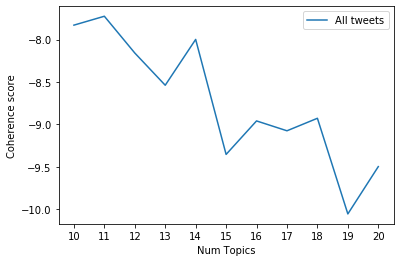

In [114]:
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))
plt.show()

In [115]:
#unigram
from pprint import pprint
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=11, random_state=2,
                                            alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics(num_words=50))

[(0,
  '0.026*"world" + 0.015*"food" + 0.013*"chang" + 0.012*"today" + 0.010*"meat" '
  '+ 0.009*"better" + 0.008*"feed" + 0.008*"thank" + 0.008*"work" + '
  '0.007*"billion" + 0.007*"team" + 0.006*"share" + 0.006*"nation" + '
  '0.006*"help" + 0.006*"time" + 0.006*"anim" + 0.006*"learn" + 0.006*"chain" '
  '+ 0.006*"year" + 0.006*"honor" + 0.006*"like" + 0.006*"check" + '
  '0.005*"ultim" + 0.005*"protein" + 0.005*"join" + 0.005*"partner" + '
  '0.005*"futur" + 0.005*"local" + 0.005*"spot" + 0.005*"fisheri" + '
  '0.005*"sector" + 0.005*"first" + 0.005*"scale" + 0.005*"prize" + '
  '0.005*"suppli" + 0.005*"tune" + 0.004*"human" + 0.004*"system" + '
  '0.004*"connect" + 0.004*"later" + 0.004*"thing" + 0.004*"challeng" + '
  '0.004*"percent" + 0.004*"free" + 0.004*"next" + 0.004*"planet" + '
  '0.004*"sustain" + 0.004*"sauc" + 0.004*"find" + 0.004*"address"'),
 (1,
  '0.017*"meat" + 0.016*"tast" + 0.013*"egg" + 0.012*"make" + 0.011*"chang" + '
  '0.009*"today" + 0.009*"women" + 0.009*"v